In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [4]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

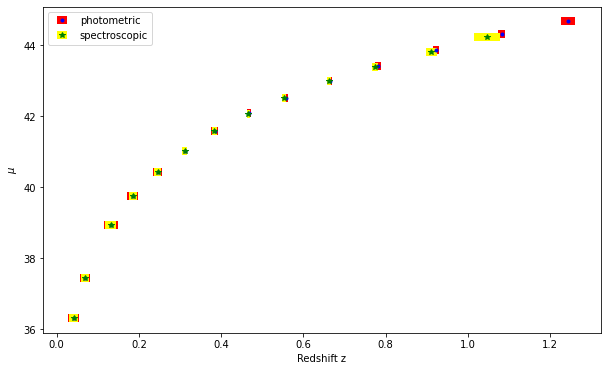

In [5]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [6]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [7]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [8]:
len(dfp)

14

In [9]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [10]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [11]:
np.shape(noise1y)

(14, 2)

In [12]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [13]:
np.shape(y), np.shape(z)

((42, 2), (42,))

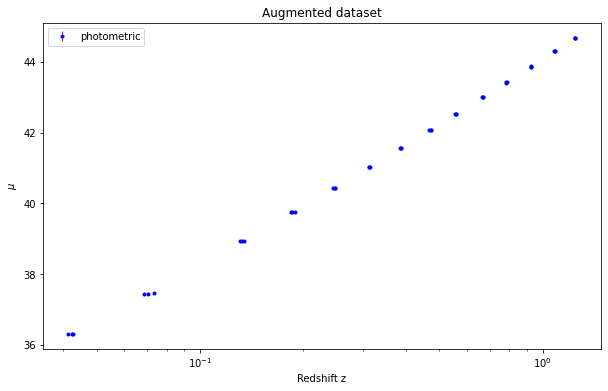

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [15]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [16]:
split = 0.9
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [17]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [18]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((35,), (37,), (9, 1), (9, 1))

In [19]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 1
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,100,100, 100])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_2 (MCDropout)     (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_3 (MCDropout)     (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2

In [20]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=5000, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/5000
37/37 [==============================] - 1s 5ms/step - loss: 861.1613 - val_loss: 855.6676
Epoch 2/5000
37/37 [==============================] - 0s 2ms/step - loss: 855.6092 - val_loss: 853.3729
Epoch 3/5000
37/37 [==============================] - 0s 2ms/step - loss: 855.7428 - val_loss: 853.5477
Epoch 4/5000
37/37 [==============================] - 0s 2ms/step - loss: 852.3268 - val_loss: 854.9300
Epoch 5/5000
37/37 [==============================] - 0s 2ms/step - loss: 848.2521 - val_loss: 845.6805
Epoch 6/5000
37/37 [==============================] - 0s 2ms/step - loss: 844.7692 - val_loss: 848.8323
Epoch 7/5000
37/37 [==============================] - 0s 2ms/step - loss: 842.7239 - val_loss: 847.6453
Epoch 8/5000
37/37 [==============================] - 0s 2ms/step - loss: 840.5322 - val_loss: 839.7780
Epoch 9/5000
37/37 [==============================] - 0s 2ms/step - loss: 833.7668 - val_loss: 840.6523
Epoch 10/5000
37/37 [==============================] - 0s 2ms/st

Epoch 80/5000
37/37 [==============================] - 0s 2ms/step - loss: 53.4668 - val_loss: 46.6863
Epoch 81/5000
37/37 [==============================] - 0s 2ms/step - loss: 67.5011 - val_loss: 75.8972
Epoch 82/5000
37/37 [==============================] - 0s 2ms/step - loss: 67.8837 - val_loss: 47.6755
Epoch 83/5000
37/37 [==============================] - 0s 2ms/step - loss: 60.9970 - val_loss: 59.2109
Epoch 84/5000
37/37 [==============================] - 0s 2ms/step - loss: 65.5544 - val_loss: 72.1171
Epoch 85/5000
37/37 [==============================] - 0s 2ms/step - loss: 61.5167 - val_loss: 77.4402
Epoch 86/5000
37/37 [==============================] - 0s 2ms/step - loss: 42.1986 - val_loss: 56.3347
Epoch 87/5000
37/37 [==============================] - 0s 2ms/step - loss: 56.2392 - val_loss: 8.0553
Epoch 88/5000
37/37 [==============================] - 0s 2ms/step - loss: 81.3405 - val_loss: 100.3978
Epoch 89/5000
37/37 [==============================] - 0s 2ms/step - loss

Epoch 159/5000
37/37 [==============================] - 0s 2ms/step - loss: 66.9103 - val_loss: 23.2672
Epoch 160/5000
37/37 [==============================] - 0s 2ms/step - loss: 55.8803 - val_loss: 25.3095
Epoch 161/5000
37/37 [==============================] - 0s 2ms/step - loss: 63.1630 - val_loss: 46.7936
Epoch 162/5000
37/37 [==============================] - 0s 2ms/step - loss: 42.2166 - val_loss: 76.9673
Epoch 163/5000
37/37 [==============================] - 0s 2ms/step - loss: 40.3461 - val_loss: 34.5150
Epoch 164/5000
37/37 [==============================] - 0s 2ms/step - loss: 41.5963 - val_loss: 64.1552
Epoch 165/5000
37/37 [==============================] - 0s 2ms/step - loss: 87.6124 - val_loss: 29.1640
Epoch 166/5000
37/37 [==============================] - 0s 2ms/step - loss: 50.4333 - val_loss: 24.3543
Epoch 167/5000
37/37 [==============================] - 0s 2ms/step - loss: 45.8365 - val_loss: 35.9350
Epoch 168/5000
37/37 [==============================] - 0s 2ms/s

37/37 [==============================] - 0s 2ms/step - loss: 38.3683 - val_loss: 46.2604
Epoch 238/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.4611 - val_loss: 25.9956
Epoch 239/5000
37/37 [==============================] - 0s 2ms/step - loss: 40.0318 - val_loss: 17.4419
Epoch 240/5000
37/37 [==============================] - 0s 2ms/step - loss: 39.2659 - val_loss: 17.8275
Epoch 241/5000
37/37 [==============================] - 0s 2ms/step - loss: 42.0439 - val_loss: 31.8460
Epoch 242/5000
37/37 [==============================] - 0s 2ms/step - loss: 58.6218 - val_loss: 51.5649
Epoch 243/5000
37/37 [==============================] - 0s 2ms/step - loss: 64.9003 - val_loss: 75.8347
Epoch 244/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.7569 - val_loss: 22.8229
Epoch 245/5000
37/37 [==============================] - 0s 2ms/step - loss: 44.3211 - val_loss: 87.8298
Epoch 246/5000
37/37 [==============================] - 0s 2ms/step - loss: 44.

Epoch 316/5000
37/37 [==============================] - 0s 2ms/step - loss: 41.4061 - val_loss: 29.5665
Epoch 317/5000
37/37 [==============================] - 0s 2ms/step - loss: 33.7729 - val_loss: 32.3871
Epoch 318/5000
37/37 [==============================] - 0s 2ms/step - loss: 33.8874 - val_loss: 3.7374
Epoch 319/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.7716 - val_loss: 86.7894
Epoch 320/5000
37/37 [==============================] - 0s 2ms/step - loss: 51.3545 - val_loss: 34.1254
Epoch 321/5000
37/37 [==============================] - 0s 2ms/step - loss: 36.1003 - val_loss: 20.2378
Epoch 322/5000
37/37 [==============================] - 0s 2ms/step - loss: 38.8649 - val_loss: 37.0029
Epoch 323/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.8310 - val_loss: 40.2038
Epoch 324/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.2271 - val_loss: 133.5685
Epoch 325/5000
37/37 [==============================] - 0s 2ms/s

Epoch 395/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.3061 - val_loss: 35.8658
Epoch 396/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.0302 - val_loss: 25.0188
Epoch 397/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.2836 - val_loss: 12.9346
Epoch 398/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.9968 - val_loss: 19.8062
Epoch 399/5000
37/37 [==============================] - 0s 2ms/step - loss: 34.7226 - val_loss: 85.9758
Epoch 400/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.9843 - val_loss: 16.3017
Epoch 401/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.3433 - val_loss: 10.4506
Epoch 402/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.2867 - val_loss: 22.9888
Epoch 403/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.1112 - val_loss: 46.8372
Epoch 404/5000
37/37 [==============================] - 0s 2ms/s

Epoch 474/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.6698 - val_loss: 11.3910
Epoch 475/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.1139 - val_loss: 13.6902
Epoch 476/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.3621 - val_loss: 25.3842
Epoch 477/5000
37/37 [==============================] - 0s 2ms/step - loss: 39.5416 - val_loss: 10.4280
Epoch 478/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.7928 - val_loss: 39.8554
Epoch 479/5000
37/37 [==============================] - 0s 2ms/step - loss: 36.5331 - val_loss: 17.5978
Epoch 480/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.6285 - val_loss: 11.0780
Epoch 481/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.0730 - val_loss: 55.7984
Epoch 482/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.2943 - val_loss: 29.5860
Epoch 483/5000
37/37 [==============================] - 0s 2ms/s

Epoch 553/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.4495 - val_loss: 12.2087
Epoch 554/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.4117 - val_loss: 9.2752
Epoch 555/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.0772 - val_loss: 19.3213
Epoch 556/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.3493 - val_loss: 46.1418
Epoch 557/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.3681 - val_loss: 28.2136
Epoch 558/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.4807 - val_loss: 3.1931
Epoch 559/5000
37/37 [==============================] - 0s 2ms/step - loss: 40.0376 - val_loss: 4.6322
Epoch 560/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.4958 - val_loss: 16.5645
Epoch 561/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.1480 - val_loss: 22.2087
Epoch 562/5000
37/37 [==============================] - 0s 2ms/step

Epoch 632/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.7824 - val_loss: 24.1439
Epoch 633/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.6217 - val_loss: 24.5492
Epoch 634/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.3278 - val_loss: 29.1190
Epoch 635/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.5291 - val_loss: 41.7984
Epoch 636/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.7091 - val_loss: 29.6829
Epoch 637/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.5179 - val_loss: 80.9565
Epoch 638/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.4724 - val_loss: 25.5765
Epoch 639/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.8189 - val_loss: 14.8404
Epoch 640/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.1923 - val_loss: 13.1994
Epoch 641/5000
37/37 [==============================] - 0s 2ms/s

Epoch 711/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.8932 - val_loss: 19.7290
Epoch 712/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.3872 - val_loss: 45.8325
Epoch 713/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.4785 - val_loss: 4.6717
Epoch 714/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.8125 - val_loss: 32.6571
Epoch 715/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.5871 - val_loss: 10.8992
Epoch 716/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.6280 - val_loss: 21.3664
Epoch 717/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.1541 - val_loss: 20.1826
Epoch 718/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.2838 - val_loss: 22.5088
Epoch 719/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.0936 - val_loss: 19.4210
Epoch 720/5000
37/37 [==============================] - 0s 2ms/st

Epoch 790/5000
37/37 [==============================] - 0s 3ms/step - loss: 32.8805 - val_loss: 11.4665
Epoch 791/5000
37/37 [==============================] - 0s 3ms/step - loss: 19.9493 - val_loss: 22.3802
Epoch 792/5000
37/37 [==============================] - 0s 3ms/step - loss: 32.7479 - val_loss: 8.1634
Epoch 793/5000
37/37 [==============================] - 0s 5ms/step - loss: 24.9967 - val_loss: 19.1452
Epoch 794/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.4233 - val_loss: 19.3211
Epoch 795/5000
37/37 [==============================] - 0s 3ms/step - loss: 35.8330 - val_loss: 15.0776
Epoch 796/5000
37/37 [==============================] - 0s 3ms/step - loss: 24.7913 - val_loss: 7.7213
Epoch 797/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.2966 - val_loss: 47.6887
Epoch 798/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.5620 - val_loss: 30.0279
Epoch 799/5000
37/37 [==============================] - 0s 2ms/ste

Epoch 869/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.3612 - val_loss: 76.4269
Epoch 870/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.4943 - val_loss: 4.3466
Epoch 871/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.0439 - val_loss: 13.2629
Epoch 872/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.4614 - val_loss: 44.4827
Epoch 873/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.6345 - val_loss: 21.1582
Epoch 874/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.9899 - val_loss: 28.5636
Epoch 875/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.6370 - val_loss: 31.7079
Epoch 876/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.6020 - val_loss: 51.8303
Epoch 877/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.0064 - val_loss: 12.3062
Epoch 878/5000
37/37 [==============================] - 0s 2ms/st

Epoch 948/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.9694 - val_loss: 17.3519
Epoch 949/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.8449 - val_loss: 25.7560
Epoch 950/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.9906 - val_loss: 8.5810
Epoch 951/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.4627 - val_loss: 46.2786
Epoch 952/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.3843 - val_loss: 11.1714
Epoch 953/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.7113 - val_loss: 20.0835
Epoch 954/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.3308 - val_loss: 24.8567
Epoch 955/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.4250 - val_loss: 17.2812
Epoch 956/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.6073 - val_loss: 39.5145
Epoch 957/5000
37/37 [==============================] - 0s 2ms/st

37/37 [==============================] - 0s 2ms/step - loss: 16.9210 - val_loss: 28.3209
Epoch 1027/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.8680 - val_loss: 47.6172
Epoch 1028/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.2834 - val_loss: 37.1913
Epoch 1029/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.7988 - val_loss: 11.0689
Epoch 1030/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.9808 - val_loss: 11.0573
Epoch 1031/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.2300 - val_loss: 20.2560
Epoch 1032/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.6491 - val_loss: 20.2068
Epoch 1033/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.9748 - val_loss: 38.9742
Epoch 1034/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.9573 - val_loss: 44.1437
Epoch 1035/5000
37/37 [==============================] - 0s 2ms/step - 

37/37 [==============================] - 0s 2ms/step - loss: 20.3641 - val_loss: 10.6846
Epoch 1105/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.8015 - val_loss: 15.0202
Epoch 1106/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.4575 - val_loss: 42.6722
Epoch 1107/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.3426 - val_loss: 29.8448
Epoch 1108/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.5149 - val_loss: 29.7780
Epoch 1109/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.1885 - val_loss: 19.2689
Epoch 1110/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.2645 - val_loss: 26.3417
Epoch 1111/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.8806 - val_loss: 69.9809
Epoch 1112/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.5917 - val_loss: 12.8597
Epoch 1113/5000
37/37 [==============================] - 0s 2ms/step - 

37/37 [==============================] - 0s 2ms/step - loss: 25.2031 - val_loss: 8.8903
Epoch 1183/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.6533 - val_loss: 30.5208
Epoch 1184/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.4299 - val_loss: 15.2276
Epoch 1185/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.4210 - val_loss: 25.5862
Epoch 1186/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.2342 - val_loss: 19.9332
Epoch 1187/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.0720 - val_loss: 11.4581
Epoch 1188/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.2804 - val_loss: 6.6450
Epoch 1189/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.6271 - val_loss: 47.1767
Epoch 1190/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.5569 - val_loss: 11.9691
Epoch 1191/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 22.1923 - val_loss: 7.3154
Epoch 1261/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.5099 - val_loss: 9.7020
Epoch 1262/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.4320 - val_loss: 21.7955
Epoch 1263/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.2102 - val_loss: 27.0549
Epoch 1264/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.9720 - val_loss: 14.7135
Epoch 1265/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.5787 - val_loss: 17.4676
Epoch 1266/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.0217 - val_loss: 22.0154
Epoch 1267/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.4200 - val_loss: 47.9847
Epoch 1268/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.8317 - val_loss: 23.5761
Epoch 1269/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 21.9781 - val_loss: 24.8099
Epoch 1339/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.6325 - val_loss: 23.6097
Epoch 1340/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.7973 - val_loss: 29.1063
Epoch 1341/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.8978 - val_loss: 5.4298
Epoch 1342/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.6187 - val_loss: 26.0470
Epoch 1343/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.9107 - val_loss: 18.7126
Epoch 1344/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.7038 - val_loss: 13.4120
Epoch 1345/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.1981 - val_loss: 4.0015
Epoch 1346/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.6000 - val_loss: 21.8031
Epoch 1347/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 15.3341 - val_loss: 23.5375
Epoch 1417/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.7972 - val_loss: 26.0574
Epoch 1418/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.0094 - val_loss: 13.3492
Epoch 1419/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.6019 - val_loss: 18.1405
Epoch 1420/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.5731 - val_loss: 12.1332
Epoch 1421/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.7252 - val_loss: 8.8999
Epoch 1422/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.7354 - val_loss: 14.0231
Epoch 1423/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.0066 - val_loss: 11.6802
Epoch 1424/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.4234 - val_loss: 27.7947
Epoch 1425/5000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 20.5275 - val_loss: 3.7016
Epoch 1495/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.9698 - val_loss: 59.0518
Epoch 1496/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.0228 - val_loss: 19.9432
Epoch 1497/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.7982 - val_loss: 47.7857
Epoch 1498/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.3072 - val_loss: 5.3957
Epoch 1499/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.6824 - val_loss: 20.1545
Epoch 1500/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.7590 - val_loss: 6.4276
Epoch 1501/5000
37/37 [==============================] - 0s 2ms/step - loss: 12.5022 - val_loss: 18.3847
Epoch 1502/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.2776 - val_loss: 34.7537
Epoch 1503/5000
37/37 [==============================] - 0s 2ms/step - los

37/37 [==============================] - 0s 2ms/step - loss: 22.4875 - val_loss: 15.8658
Epoch 1573/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.9814 - val_loss: 6.0339
Epoch 1574/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.0075 - val_loss: 28.1839
Epoch 1575/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.1117 - val_loss: 9.8481
Epoch 1576/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.9812 - val_loss: 11.6072
Epoch 1577/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.8013 - val_loss: 25.8907
Epoch 1578/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.1019 - val_loss: 13.0108
Epoch 1579/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.5327 - val_loss: 15.9474
Epoch 1580/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.0142 - val_loss: 18.7476
Epoch 1581/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 28.1120 - val_loss: 29.5177
Epoch 1651/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.1615 - val_loss: 18.9464
Epoch 1652/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.9068 - val_loss: 65.5131
Epoch 1653/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.3117 - val_loss: 24.7920
Epoch 1654/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.7861 - val_loss: 10.5584
Epoch 1655/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.3599 - val_loss: 26.1684
Epoch 1656/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.9328 - val_loss: 8.9514
Epoch 1657/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.3579 - val_loss: 40.5696
Epoch 1658/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.8758 - val_loss: 5.6034
Epoch 1659/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 17.1366 - val_loss: 30.7696
Epoch 1729/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.5389 - val_loss: 5.9405
Epoch 1730/5000
37/37 [==============================] - 0s 2ms/step - loss: 8.9466 - val_loss: 8.4845
Epoch 1731/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.1056 - val_loss: 37.0601
Epoch 1732/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.1916 - val_loss: 33.5254
Epoch 1733/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.0380 - val_loss: 0.3822
Epoch 1734/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.7235 - val_loss: 33.1474
Epoch 1735/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.8745 - val_loss: 9.5378
Epoch 1736/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.3681 - val_loss: 44.6828
Epoch 1737/5000
37/37 [==============================] - 0s 2ms/step - loss:

37/37 [==============================] - 0s 2ms/step - loss: 19.2865 - val_loss: 24.5346
Epoch 1807/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.8963 - val_loss: 5.5193
Epoch 1808/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.4799 - val_loss: 34.0025
Epoch 1809/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.3343 - val_loss: 9.8742
Epoch 1810/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.9465 - val_loss: 24.8363
Epoch 1811/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.6355 - val_loss: 60.0977
Epoch 1812/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.9019 - val_loss: 6.4117
Epoch 1813/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.9745 - val_loss: 19.8780
Epoch 1814/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.0001 - val_loss: 13.8589
Epoch 1815/5000
37/37 [==============================] - 0s 2ms/step - los

37/37 [==============================] - 0s 2ms/step - loss: 17.3501 - val_loss: 22.8091
Epoch 1885/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.5281 - val_loss: 15.3879
Epoch 1886/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.4361 - val_loss: 21.1015
Epoch 1887/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.1110 - val_loss: 20.2200
Epoch 1888/5000
37/37 [==============================] - 0s 2ms/step - loss: 10.9897 - val_loss: 38.1281
Epoch 1889/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.7538 - val_loss: 21.6848
Epoch 1890/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.9697 - val_loss: 22.2430
Epoch 1891/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.1988 - val_loss: 14.9250
Epoch 1892/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.1789 - val_loss: 9.3167
Epoch 1893/5000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 24.9455 - val_loss: 16.6345
Epoch 1963/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.4440 - val_loss: 10.4932
Epoch 1964/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.1096 - val_loss: 5.4142
Epoch 1965/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.1273 - val_loss: 31.7647
Epoch 1966/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.3387 - val_loss: 37.5665
Epoch 1967/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.9571 - val_loss: 19.9233
Epoch 1968/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.4459 - val_loss: 17.1588
Epoch 1969/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.6438 - val_loss: 16.2444
Epoch 1970/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.5086 - val_loss: 3.8890
Epoch 1971/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 19.8408 - val_loss: 6.3740
Epoch 2041/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.5023 - val_loss: 51.2126
Epoch 2042/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.6961 - val_loss: 17.1684
Epoch 2043/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.2655 - val_loss: 12.5015
Epoch 2044/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.2014 - val_loss: 13.7160
Epoch 2045/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.6529 - val_loss: 47.7733
Epoch 2046/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.5930 - val_loss: 23.7438
Epoch 2047/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.0473 - val_loss: 4.9402
Epoch 2048/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.6899 - val_loss: 36.6957
Epoch 2049/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 19.2555 - val_loss: 29.1287
Epoch 2119/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.2448 - val_loss: 23.7646
Epoch 2120/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.4721 - val_loss: 7.5126
Epoch 2121/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.0513 - val_loss: 20.6806
Epoch 2122/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.1456 - val_loss: 5.7702
Epoch 2123/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.8662 - val_loss: 8.7607
Epoch 2124/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.7776 - val_loss: 17.7378
Epoch 2125/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.9180 - val_loss: 10.3387
Epoch 2126/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.5985 - val_loss: 24.6028
Epoch 2127/5000
37/37 [==============================] - 0s 2ms/step - los

37/37 [==============================] - 0s 2ms/step - loss: 18.7930 - val_loss: 9.6764
Epoch 2197/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.1308 - val_loss: 15.0721
Epoch 2198/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.1071 - val_loss: 4.8912
Epoch 2199/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.0946 - val_loss: 20.7507
Epoch 2200/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.7753 - val_loss: 9.3613
Epoch 2201/5000
37/37 [==============================] - 0s 2ms/step - loss: 10.3706 - val_loss: 13.8891
Epoch 2202/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.1839 - val_loss: 20.0229
Epoch 2203/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.6042 - val_loss: 8.5327
Epoch 2204/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.9436 - val_loss: 20.0923
Epoch 2205/5000
37/37 [==============================] - 0s 2ms/step - loss

In [21]:
model_train.history['val_loss'][-1]

9.613519668579102

(0.0, 200.0)

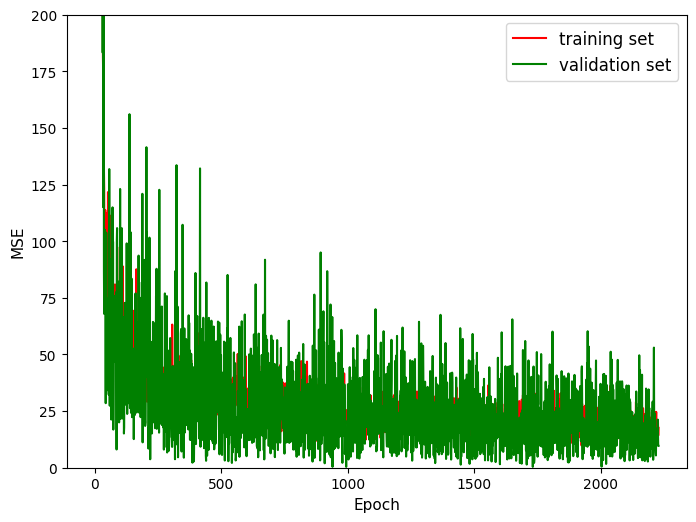

In [22]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)

In [23]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 200 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


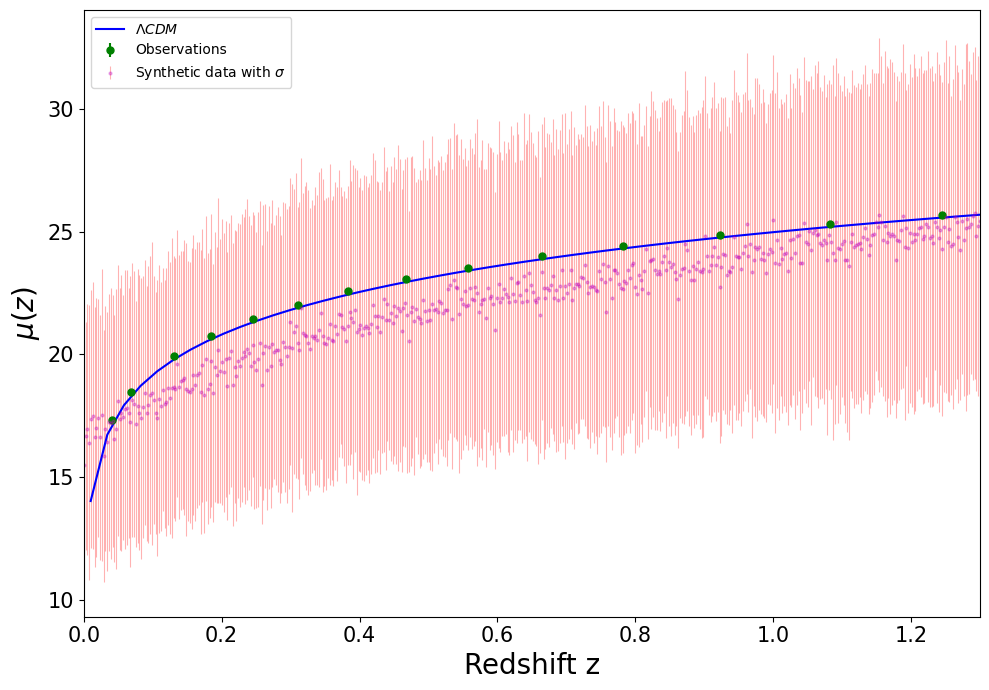

In [24]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors